<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
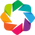

In [1]:
import sys

sys.path.insert(0, "..")
sys.path.insert(0, "../../..")

from Utilities.Utils import *
from Utilities.Processing import *
from Utilities.Ballpushing_utils import *
from Utilities.HoloviewsTemplates import hv_main
import holoviews as hv

hv.extension("bokeh")

# Get the list of experiments

In [2]:
# Get the data path
Datapath = get_data_path()

# Get all folders with "TNT_Fine" in the name

Folders = [
    f for f in os.listdir(Datapath) if "TNT_Fine" in f and "Tracked" in f and os.path.isdir(Datapath / f)
]

Folders

['231222_TNT_Fine_1_Videos_Tracked',
 '231130_TNT_Fine_3_Videos_Tracked',
 '231205_TNT_Fine_2_Videos_Tracked',
 '240110_TNT_Fine_1_Videos_Tracked',
 '231212_TNT_Fine_2_Videos_Tracked',
 '231124_TNT_Fine_3_Videos_Tracked',
 '231124_TNT_Fine_1_Videos_Tracked',
 '231208_TNT_Fine_2_Videos_Tracked',
 '231122_TNT_Fine_2_Videos_Tracked',
 '231121_TNT_Fine_2_Videos_Tracked',
 '231115_TNT_Fine_1_Videos_Tracked',
 '240111_TNT_Fine_3_Videos_Tracked',
 '231124_TNT_Fine_2_Videos_Tracked',
 '231130_TNT_Fine_1_Videos_Tracked',
 '240111_TNT_Fine_2_Videos_Tracked',
 '240110_TNT_Fine_3_Videos_Tracked',
 '231128_TNT_Fine_1_Videos_Tracked',
 '231208_TNT_Fine_3_Videos_Tracked',
 '240104_TNT_Fine_1_Videos_Tracked',
 '231207_TNT_Fine_3_Videos_Tracked',
 '231128_TNT_Fine_2_Videos_Tracked',
 '231201_TNT_Fine_3_Videos_Tracked',
 '231205_TNT_Fine_3_Videos_Tracked',
 '231207_TNT_Fine_1_Videos_Tracked',
 '231222_TNT_Fine_2_Videos_Tracked',
 '231206_TNT_Fine_1_Videos_Tracked',
 '240109_TNT_Fine_1_Videos_Tracked',
 

In [3]:
# Generate Experiment objects from each folder

Experiments = [Experiment(Datapath / f) for f in Folders]

240111_TNT_Fine_3_Videos_Tracked_arena4_corridor2 is dead or in poor condition
231124_TNT_Fine_2_Videos_Tracked_arena2_corridor5 is empty
231124_TNT_Fine_2_Videos_Tracked_arena2_corridor6 is empty
240111_TNT_Fine_2_Videos_Tracked_arena2_corridor1 is dead or in poor condition
231208_TNT_Fine_3_Videos_Tracked_arena8_corridor5 is empty
231208_TNT_Fine_3_Videos_Tracked_arena8_corridor6 is empty
240105_TNT_Fine_1_Videos_Tracked_arena1_corridor6 is dead or in poor condition
231206_TNT_Fine_2_Videos_Tracked_arena7_corridor3 is dead or in poor condition
231208_TNT_Fine_1_Videos_Tracked_arena2_corridor6 is empty
231208_TNT_Fine_1_Videos_Tracked_arena7_corridor6 is dead or in poor condition
240104_TNT_Fine_3_Videos_Tracked_arena6_corridor4 is dead or in poor condition
231213_TNT_Fine_3_Videos_Tracked_arena5_corridor6 is empty
231117_TNT_Fine_3_Videos_Tracked_arena3_corridor2 is dead or in poor condition
Genotype None not found in brain regions table for 231130_TNT_Fine_2_Videos_Tracked_arena1_co

In [3]:
savepath = get_labserver() / "Experimental_data/MultiMazeRecorder/Datasets/240129_TNT_Fine_Experiments.pkl"


In [ ]:

save_object(Experiments, savepath.as_posix())

In [4]:
# Load the experiments from the saved file
Experiments = load_object(savepath.as_posix())

In [ ]:
Experiments

In [5]:
data = Dataset(Experiments)

In [6]:
print(data)

Dataset with 3160 flies and 59 experiments
keyword: TNT, Fine, 1


In [7]:
data.generate_dataset("summary")

Error occurred while adding metadata for fly 231222_TNT_Fine_1_Videos_Tracked_arena6_corridor5: cannot reindex on an axis with duplicate labels
Current dataset:
   NumberEvents  FinalEvent  FinalTime  SignificantEvents  SignificantFirst  \
0            22          20  10.655172                  4                 4   

   SignificantFirstTime  CumulatedBreaks  Pushes  Pulls  \
0           1064.103448      3492.344828       4      0   

                                                 fly  \
0  231222_TNT_Fine_1_Videos_Tracked_arena6_corridor5   

                         experiment  
0  231222_TNT_Fine_1_Videos_Tracked  
Error occurred while adding metadata for fly 231222_TNT_Fine_1_Videos_Tracked_arena6_corridor1: cannot reindex on an axis with duplicate labels
Current dataset:
   NumberEvents  FinalEvent  FinalTime  SignificantEvents  SignificantFirst  \
0            65          26   29.62069                  5                10   

   SignificantFirstTime  CumulatedBreaks  Pushes  Pu

,NumberEvents,FinalEvent,FinalTime,SignificantEvents,SignificantFirst,SignificantFirstTime,CumulatedBreaks,Pushes,Pulls,fly,...,Brain region,Date,Genotype,Period,FeedingState,Orientation,Light,Crossing,SampleSize,label
0,65,59,45.310345,30,0,12.000000,2609.862069,15,15,231222_TNT_Fine_1_Videos_Tracked_arena2_corridor5,...,Olfaction,231222,TNTxZ1665,PM14,starved_noWater,std,on,1,18,41731 (IR8a-GAL4) (n = 18)
1,56,0,11.793103,9,0,12.172414,3015.034483,4,5,231222_TNT_Fine_1_Videos_Tracked_arena2_corridor1,...,Olfaction,231222,TNTxZ1665,PM14,starved_noWater,std,on,1,18,41731 (IR8a-GAL4) (n = 18)
2,91,5,34.862069,30,0,34.517241,1891.862069,15,15,231222_TNT_Fine_1_Videos_Tracked_arena2_corridor4,...,Olfaction,231222,TNTxZ1665,PM14,starved_noWater,std,on,1,18,41731 (IR8a-GAL4) (n = 18)
3,97,75,17.620690,22,0,44.310345,2461.241379,18,4,231222_TNT_Fine_1_Videos_Tracked_arena2_corridor2,...,Olfaction,231222,TNTxZ1665,PM14,starved_noWater,std,on,1,18,41731 (IR8a-GAL4) (n = 18)
4,104,95,63.000000,30,0,28.482759,2115.137931,14,16,231222_TNT_Fine_1_Videos_Tracked_arena2_corridor6,...,Olfaction,231222,TNTxZ1665,PM14,starved_noWater,std,on,1,18,41731 (IR8a-GAL4) (n = 18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,67,2,60.068966,8,1,31.896552,1439.103448,5,3,231213_TNT_Fine_1_Videos_Tracked_arena5_corridor5,...,Neuropeptide,231213,TNTxZ1692,PM14,starved_noWater,std,on,1,5,51983 (Mip-GAL4 1M) (n = 5)
3108,28,0,98.655172,5,0,22.172414,2786.931034,4,1,231213_TNT_Fine_1_Videos_Tracked_arena5_corridor1,...,Neuropeptide,231213,TNTxZ1692,PM14,starved_noWater,std,on,1,5,51983 (Mip-GAL4 1M) (n = 5)
3109,74,13,20.344828,5,4,272.862069,2099.689655,5,0,231213_TNT_Fine_1_Videos_Tracked_arena5_corridor4,...,Neuropeptide,231213,TNTxZ1692,PM14,starved_noWater,std,on,1,5,51983 (Mip-GAL4 1M) (n = 5)
3110,38,0,25.965517,2,0,13.517241,1505.689655,2,0,231213_TNT_Fine_1_Videos_Tracked_arena5_corridor6,...,Neuropeptide,231213,TNTxZ1692,PM14,starved_noWater,std,on,1,5,51983 (Mip-GAL4 1M) (n = 5)


In [9]:
mydata = data.data

In [10]:
noNa = mydata.dropna(subset=["FinalEvent"])

In [13]:
# check for non numeric values in FinalEvent

noNa[noNa["FinalEvent"].apply(lambda x: not isinstance(x, int))]

,NumberEvents,FinalEvent,FinalTime,SignificantEvents,SignificantFirst,SignificantFirstTime,CumulatedBreaks,Pushes,Pulls,fly,...,Brain region,Date,Genotype,Period,FeedingState,Orientation,Light,Crossing,SampleSize,label


In [14]:
# Check for duplicate or missing indices

noNa[noNa.index.duplicated()]

,NumberEvents,FinalEvent,FinalTime,SignificantEvents,SignificantFirst,SignificantFirstTime,CumulatedBreaks,Pushes,Pulls,fly,...,Brain region,Date,Genotype,Period,FeedingState,Orientation,Light,Crossing,SampleSize,label


In [15]:
noNa = noNa.reset_index(drop=True)

In [12]:
type(mydata["FinalEvent"][0])

int

In [33]:
vdim = ["FinalEvent"]

In [34]:
for metric in vdim:
    if metric in data.data.columns:
        print(f"{metric} exists in the dataset.")
    else:
        print(f"{metric} does not exist in the dataset.")

FinalEvent exists in the dataset.


In [37]:
# Assuming 'data' is your DataFrame and 'vdim' is your metric
print(f"Data type for {vdim}: {mydata[vdim].dtypes}")

Data type for ['FinalEvent']: FinalEvent    object
dtype: object


In [39]:
# Find unique data types I have in the FinalEvent column
noNa["FinalEvent"].apply(lambda x: type(x)).unique()

array([<class 'int'>], dtype=object)

In [26]:
data.jitter_boxplot(data.data, "FinalEvent", show=False, save=True)

100%|██████████| 300/300 [00:00<00:00, 201649.23it/s]

AbbreviatedException: ValueError: List parameter 'PipelineMeta.vdims' length must be between 1 and 1 (inclusive), not 0.

To view the original traceback, catch this exception and call print_traceback() method.

In [24]:
# Make a subset of the data that removes None rows from "FinalEvent"

subsetfinal = data.data.dropna(subset=["FinalEvent"])

In [ ]:
data.jitter_boxplot(subsetfinal, "FinalEvent", show=False, save=True)